In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import cartesian_to_spherical
from matplotlib import animation
from poliastro.bodies import Moon
from poliastro.twobody import Orbit

from src import CraterDetector
from src.common.coordinates import nadir_attitude
from src.common.conics import *
from src.common.data import DataGenerator
from src.matching import CraterDatabase

In [15]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv",
                              latlims=(0, 30),
                              longlims=(0, 30),
                              diamlims=(5, 40),
                              radius=200,
                              )

In [16]:
cam = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv",
                                         diamlims=(4, 40),
                                         axis_threshold=(1, 250),
                                         )

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


In [17]:
cda = CraterDetector()
cda.load_state_dict(torch.load("../blobs/CraterRCNN.pth"))
cda.to('cuda')
cda.eval()
print()

In [18]:
from src.matching.position_estimation import systems_dynamics_matrix, Hx, HJacobian

In [26]:
# a = 2000 * u.km
# ecc = 0.005 * u.one
# inc = 80 * u.deg
# raan = 18 * u.deg
# argp = 0 * u.deg
# nu = 0 * u.deg

a = 2000 * u.km
ecc = 0.005 * u.one
inc = 60 * u.deg
raan = 18 * u.deg
argp = 0 * u.deg
nu = 0 * u.deg

orb = Orbit.from_classical(Moon, a, ecc, inc, raan, argp, nu)

In [70]:
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from decimal import Decimal
ekf = ExtendedKalmanFilter(dim_x=6, dim_z=3)

dt = 1e-1
dt_update = 0.5
t_range = np.arange(0, 500, dt)

cam.position = np.array(orb.r)[:, None]
cam.point_nadir()

ekf.P[:3, :3] *= 500**2
ekf.P[3:, 3:] *= 2**2
ekf.Q = Q_discrete_white_noise(2, dt=dt, var=1e-4, block_size=3, order_by_dim=False)
# ekf.Q[3:, 3:] = Q_discrete_white_noise(3, dt=dt, var=1)

# ekf.R = np.array([[ 0.6833364 ,  0.11076215, -0.09880642],
#                   [ 0.11076215,  0.0520415 , -0.007652  ],
#                   [-0.09880642, -0.007652  ,  0.05631011]])
ekf.R *= 1


x_true = np.array(orb.r)[:, None]
v_true = np.array(orb.v)[:, None]

initialized_position = np.concatenate((np.array(orb.r) + np.random.uniform(-500, 500, 3),
                                       np.array(orb.v) + np.random.uniform(-1, 1, 3)))[:, None]
ekf.x = initialized_position
print(repr(ekf))
cam.position = x_true
cam.point_nadir()

ground_truth = np.zeros((len(t_range), 6, 1))
measurements = np.zeros((len(t_range), 3, 1))
predictions = np.zeros((len(t_range), 6, 1))
uncertainty = np.zeros((len(t_range)))
detections = np.zeros((len(t_range)))
matches = np.zeros(((len(t_range))))
update_mask = np.full(len(t_range), False, dtype=bool)

match_trial_args = dict(
    sigma_pix=6,
    k=30,
    max_distance=0.040,
    batch_size=2000,
    residual_threshold=0.025,
    max_trials=1500
)


for i, t in enumerate(t_range):
    ground_truth[i] = np.concatenate((x_true, v_true))
    predictions[i] = ekf.x
    uncertainty[i] = LA.norm(ekf.S)

    ekf.F = np.identity(6) + systems_dynamics_matrix(ekf.x)*dt
    ekf.predict()

    if float(Decimal(str(t)) % Decimal(str(dt_update))) == 0:
        image = cam.generate_image()
        image = torch.as_tensor(image[None, None, ...]).to('cuda')
        with torch.no_grad():
            pred = cda(image)[0]

        scores = pred['scores']
        A_detections = pred['ellipse_matrices'][scores > 0.75].cpu().numpy()
        detections[i] = len(A_detections)
        if len(A_detections) < 4:
            continue
        position_regressor = db.query_position(A_detections, T=cam.T, K=cam.K,
                                               **match_trial_args)

        if position_regressor.reprojection_match():
            latest_position_error = LA.norm(position_regressor.est_pos_verified - ekf.x[:3])
            if latest_position_error < max(10, LA.norm(ekf.P[:3, :3])):
                print(f"Update! Error: {LA.norm(position_regressor.est_pos_verified - cam.position)*1000:.1f} m")
                update_mask[i] = True
                measurements[i] = position_regressor.est_pos_verified
                matches[i] = position_regressor.num_verified
                ekf.update(position_regressor.est_pos_verified, HJacobian, Hx)

        print(f"[t = {t:03.1f}s, lat={cam.latitude:.1f}, long={cam.longitude:.1f}] EKF position error:  {LA.norm(ekf.x[:3] - cam.position):12.2f} km"
              f"\t Uncertainty: {LA.norm(ekf.P[:3, :3]):.2f}")

        if LA.norm(ekf.x[:3] - cam.position) > 25 and LA.norm(ekf.P[:3, :3]) < 1e2:
            break

    x_true = np.array(orb.propagate(t*u.second).r)[:, None]
    v_true = np.array(orb.propagate(t*u.second).v)[:, None]
    cam.position = x_true
    cam.point_nadir()

KalmanFilter object
x = [[ 1.58690563e+03  2.56982826e+02 -3.94294072e+02 -6.21807920e-02   1.59038184e+00  8.44312349e-01]].T
P = [[2.5e+05 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
     [0.0e+00 2.5e+05 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
     [0.0e+00 0.0e+00 2.5e+05 0.0e+00 0.0e+00 0.0e+00]
     [0.0e+00 0.0e+00 0.0e+00 4.0e+00 0.0e+00 0.0e+00]
     [0.0e+00 0.0e+00 0.0e+00 0.0e+00 4.0e+00 0.0e+00]
     [0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 4.0e+00]]
x_prior = [[0. 0. 0. 0. 0. 0.]].T
P_prior = [[1. 0. 0. 0. 0. 0.]
           [0. 1. 0. 0. 0. 0.]
           [0. 0. 1. 0. 0. 0.]
           [0. 0. 0. 1. 0. 0.]
           [0. 0. 0. 0. 1. 0.]
           [0. 0. 0. 0. 0. 1.]]
F = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 1. 0. 0. 0.]
     [0. 0. 0. 1. 0. 0.]
     [0. 0. 0. 0. 1. 0.]
     [0. 0. 0. 0. 0. 1.]]
Q = [[2.5e-09 0.0e+00 0.0e+00 5.0e-08 0.0e+00 0.0e+00]
     [0.0e+00 2.5e-09 0.0e+00 0.0e+00 5.0e-08 0.0e+00]
     [0.0e+00 0.0e+00 2.5e-09 0.0e+00 0.0e+00 5.0e-08]
     

In [74]:
y_LVLH = ground_truth[:, 3:].copy()
y_LVLH /= LA.norm(y_LVLH, axis=(1, 2), keepdims=True)

z_LVLH = ground_truth[:, :3].copy()
z_LVLH /= LA.norm(z_LVLH, axis=(1, 2), keepdims=True)

x_LVLH = np.cross(y_LVLH, z_LVLH, axis=-2)
x_LVLH /= LA.norm(x_LVLH, axis=(1, 2), keepdims=True)

T_LVLH = LA.inv(np.concatenate((x_LVLH, y_LVLH, z_LVLH), axis=-1))
error = (ground_truth - predictions).copy()
measurement_error = (ground_truth[update_mask, :3] - measurements[update_mask]).copy()
along_track_error, cross_track_error, radial_error = (T_LVLH @ error[:, :3]).T[0]
along_track_error_measurement, cross_track_error_measurement, radial_error_measurement = (T_LVLH[update_mask] @ measurement_error[:, :3]).T[0]

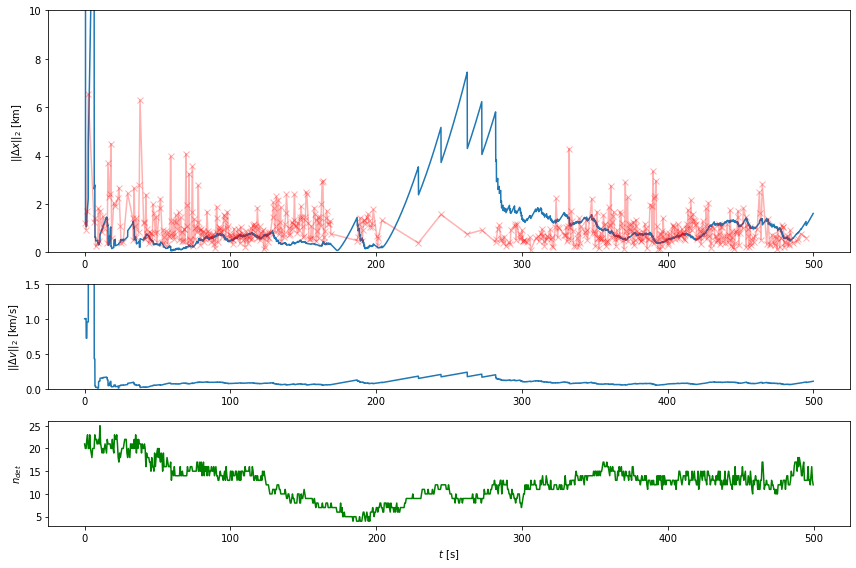

In [75]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(4, 1)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

ax1.plot(t_range, LA.norm(error[:, :3], axis=(1, 2)))
ax1.plot(t_range[update_mask], LA.norm(measurement_error, axis=(1, 2)), 'rx-', alpha=0.3)
ax1.set_ylim((0, 10))
ax1.set_ylabel("$||\Delta x||_2$ [km]")

ax2.plot(t_range, LA.norm(error[:, 3:], axis=(1, 2)))
ax2.set_ylabel(r"$||\Delta {v}||_2$ [km/s]")
ax2.set_ylim((0, 1.5))

ax3.plot(t_range[np.where(detections != 0)], detections[detections != 0], 'g-')
# ax3.stem(t_range[np.where(detections != 0)], matches[detections != 0]//3)
ax3.set_ylabel("$n_{det}$")
ax3.set_xlabel("$t$ [s]")
fig.tight_layout()
fig.savefig("../output/orbit_simulation_test.pdf")

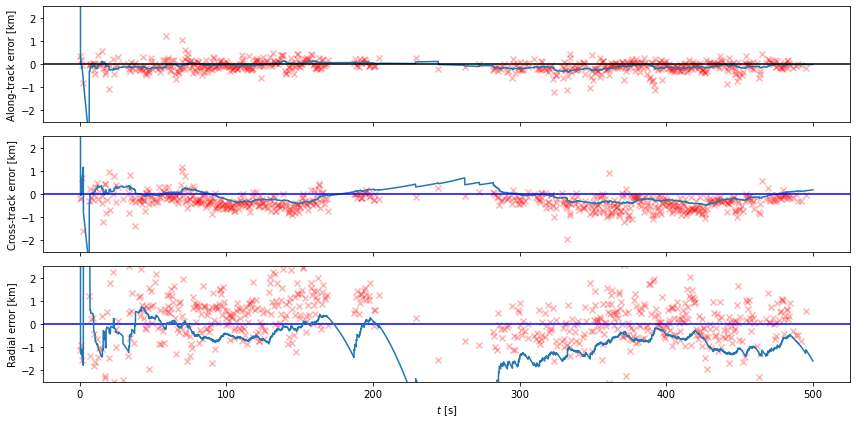

In [76]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex='all', sharey='all')

axes[0].plot(t_range, along_track_error)
axes[0].scatter(t_range[update_mask], along_track_error_measurement, marker='x', color='r', alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='-')
axes[0].set_ylabel(r'Along-track error [km]')
axes[0].set_ylim((-2.5, 2.5))


axes[1].plot(t_range, cross_track_error)
axes[1].scatter(t_range[update_mask], cross_track_error_measurement, marker='x', color='r', alpha=0.3)
axes[1].axhline(y=0, color='b', linestyle='-')
axes[1].set_ylabel(r'Cross-track error [km]')
axes[2].scatter(t_range[update_mask], radial_error_measurement, marker='x', color='r', alpha=0.3)
axes[2].axhline(y=0, color='b', linestyle='-')
axes[2].plot(t_range, radial_error)
axes[2].set_ylabel(r'Radial error [km]')

axes[2].set_xlabel(r'$t$ [s]')
fig.tight_layout()
fig.savefig('../output/orbit_simulation_test_components.pdf')


In [42]:
# cam2 = DataGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv",
#                                           diamlims=(4, 40),
#                                           axis_threshold=(1, 250),
#                                           resolution=1024
#                                           )

In [ ]:
# fps = 30
# n_seconds = 15
# fig, ax = plt.subplots(figsize=(8,8))
# cam2.position = np.array(orb.r)[:, None]
# cam2.point_nadir()
# image = cam2.generate_image()
# im = ax.imshow(image, cmap='gray')
# ax.axis('off')
# def animation_func(i):
#     if i % fps == 0:
#         print('.', end ='' )
#     cam2.position = np.array(orb.propagate(i*dt*u.second).r)[:, None]
#     cam2.rotate('pitch', i//fps*0.003)
#     image = cam2.generate_image()
#     # plot_conics(cam2.craters_in_image(), ax=ax)
#     im.set_array(image)
#     return [im]
#
# anim = animation.FuncAnimation(
#     fig,
#     animation_func,
#     frames = n_seconds * fps,
#     interval = 1000 / fps, # in ms
# )
# fig.tight_layout()
#
# anim.save('../output/test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')
ax.imshow(image, cmap='gray')
plot_conics(cam2.craters_in_image(), resolution=(1024, 1024), ax=ax)
ax.collections

In [ ]:
image.shape
